In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
from GaussianCopulaImp.low_rank_gaussian_copula import LowRankGaussianCopula
from GaussianCopulaImp.helper_data_generation import generate_sigma, generate_mixed_from_gc, generate_LRGC
from GaussianCopulaImp.helper_evaluation import get_rmse, error_by_reliability
from GaussianCopulaImp.helper_mask import mask

## Confidence interval under full rank Gaussian copula model

We use a 2000*15 dimensional dataset generated from the Gaussian copula model whose marginals are exponential distribution with rate parameter 1/3. The coverage results are robust to different marginal distribution specification.

In [3]:
seed = 101
var_types = {'cont':list(range(15)), 'ord':[], 'bin':[]}
n = 2000

In [4]:
sigma = generate_sigma(seed, p=sum([len(value) for value in var_types.values()]))
X = generate_mixed_from_gc(sigma=sigma, n=n, seed=seed, var_types=var_types)
X_masked = mask(X, mask_fraction=0.4, seed=seed)

In [5]:
model = GaussianCopula()

In [6]:
out = model.impute_missing(X=X_masked,verbose=True)

Copula correlation change ratio:  0.1247
Copula correlation change ratio:  0.068
Copula correlation change ratio:  0.0383
Copula correlation change ratio:  0.0233
Copula correlation change ratio:  0.0153
Copula correlation change ratio:  0.0107
Convergence at iteration 7


In [7]:
get_rmse(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked, relative = True)

0.5222093777725176

In [8]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly higher than the specified coverage rate

In [9]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.881 with specified coverage rate 0.850
The actual coverage rate is 0.922 with specified coverage rate 0.900
The actual coverage rate is 0.965 with specified coverage rate 0.950


### Reliability under full rank Gaussian copula model

In [10]:
reliability = model.get_reliability_cont(Ximp = out['imputed_data'])

In [11]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=out['imputed_data'])

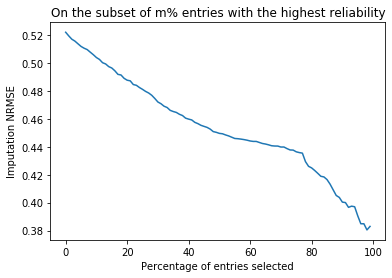

In [12]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')

## Confidence interval under low rank Gaussian copula model

We use a 500*200 dimensional dataset generated from the low rank Gaussian copula model whose marginals are cubic of standard normals. The coverage results are robust to different marginal distribution specification.

In [13]:
seed = 101
var_types = {'cont':list(range(200)), 'ord':[], 'bin':[]}

In [14]:
X, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, sigma=0.1, 
                             n=500, cont_transform=lambda x:x**3,
                             seed=seed)

X_masked = mask(X, mask_fraction = 0.4, seed=seed)

In [15]:
model = LowRankGaussianCopula()
out = model.impute_missing(X=X_masked, rank=10, verbose=True)

Ater initialization, W has shape (200, 10) and sigma is 0.13660508507418753
Interation 1: sigma estimate 0.105, copula  parameter change ratio 0.064, likelihood 85624.238
Interation 2: sigma estimate 0.100, copula  parameter change ratio 0.006, likelihood 98433.576
Interation 3: sigma estimate 0.099, copula  parameter change ratio 0.003, likelihood 100624.374
early stop because changed likelihood below 1%


In [16]:
get_rmse(x_imp = out['imputed_data'], x_true = X, x_obs = X_masked, relative = True)

0.5177723167413107

In [17]:
cover_rate = {}
for alpha in [0.85, 0.9, 0.95]:
    out_confidence_interval = model.get_imputed_confidence_interval(alpha = alpha)
    missing_loc = np.isnan(X_masked)
    lower, upper = out_confidence_interval['lower'], out_confidence_interval['upper']
    cover = (lower[missing_loc] < X[missing_loc]) & (upper[missing_loc] > X[missing_loc])
    cover_rate[alpha] = np.array(cover).mean()

The returned confidence intervals are slightly lower than the specified coverage rate

In [18]:
for key, val in cover_rate.items():
    print(f'The actual coverage rate is {val:.3f} with specified coverage rate {key:.3f}')

The actual coverage rate is 0.824 with specified coverage rate 0.850
The actual coverage rate is 0.875 with specified coverage rate 0.900
The actual coverage rate is 0.930 with specified coverage rate 0.950


In [19]:
reliability = model.get_reliability_cont(Ximp = out['imputed_data'])

In [20]:
nrmse_by_reliability = error_by_reliability('NRMSE', reliability, 
                                            xtrue=X, ximp=out['imputed_data'])

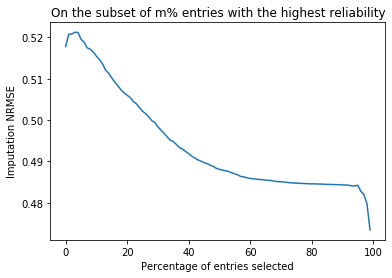

In [21]:
fig,ax = plt.subplots()
ax.plot(nrmse_by_reliability)
_ = ax.set_ylabel('Imputation NRMSE')
_ = ax.set_xlabel('Percentage of entries selected')
_ = ax.set_title('On the subset of m% entries with the highest reliability')